In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
%reload_ext lab_black

In [3]:
import logging
import os
import sys
from argparse import ArgumentParser
from signal import SIGUSR1, SIGUSR2, signal
from subprocess import PIPE, run

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from scipy.ndimage import label
from tqdm.auto import tqdm

from loren_frank_data_processing import save_xarray
from replay_trajectory_classification import (
    ClusterlessClassifier,
    SortedSpikesClassifier,
)
from src.analysis import get_place_field_max, get_sleep_replay_info, reshape_to_segments
from src.load_data import get_sleep_and_prev_run_epochs, load_sleep_data
from src.parameters import (
    FIGURE_DIR,
    PROBABILITY_THRESHOLD,
    PROCESSED_DATA_DIR,
    SAMPLING_FREQUENCY,
    TRANSITION_TO_CATEGORY,
)
from src.visualization import (
    plot_category_counts,
    plot_category_duration,
    plot_ripple_decode_1D,
)

In [4]:
FORMAT = "%(asctime)s %(message)s"

logging.basicConfig(level="INFO", format=FORMAT, datefmt="%d-%b-%y %H:%M:%S")

In [5]:
sleep_epoch_key = "bon", 3, 3

In [6]:
sleep_epoch_keys, prev_run_epoch_keys = get_sleep_and_prev_run_epochs()
prev_run_epoch_key = prev_run_epoch_keys[sleep_epoch_keys.index(sleep_epoch_key)]

In [7]:
data_type, dim = "clusterless", "1D"

In [8]:
logging.info("Loading data...")
data = load_sleep_data(sleep_epoch_key)

06-Mar-20 10:16:41 Loading data...


In [9]:
model_name = os.path.join(
    PROCESSED_DATA_DIR,
    (
        f"{prev_run_epoch_key[0]}_{prev_run_epoch_key[1]:02}_"
        f"{prev_run_epoch_key[2]:02}_{data_type}_{dim}_model.pkl"
    ),
)
try:
    results = xr.open_dataset(
        os.path.join(
            PROCESSED_DATA_DIR,
            (
                f"{sleep_epoch_key[0]}_{sleep_epoch_key[1]:02}"
                f"_{sleep_epoch_key[2]:02}.nc"
            ),
        ),
        group=f"/{data_type}/{dim}/classifier/ripples/",
    )
    logging.info("Found existing results. Loading...")
    ripple_times = data["ripple_times"].loc[:, ["start_time", "end_time"]]
    spikes = (
        ((data["multiunit"].sum("features") > 0) * 1.0)
        .to_dataframe(name="spikes")
        .unstack()
    )
    spikes.columns = data["tetrode_info"].tetrode_id
    ripple_spikes = reshape_to_segments(spikes, ripple_times)
    classifier = ClusterlessClassifier.load_model(model_name)
    logging.info(classifier)
except (FileNotFoundError, OSError):
    classifier = ClusterlessClassifier.load_model(model_name)
    logging.info(classifier)

06-Mar-20 10:17:36 ClusterlessClassifier(continuous_transition_types=[['random_walk', 'uniform',
                                                    'identity'],
                                                   ['uniform', 'uniform',
                                                    'uniform'],
                                                   ['random_walk', 'uniform',
                                                    'identity']],
                      discrete_transition_diag=0.98,
                      discrete_transition_type='strong_diagonal',
                      infer_track_interior=True,
                      initial_conditions_type='uniform_on_track',
                      model=<class 'replay_trajectory_classification.misc.NumbaKDE'>,
                      model_kwargs={'bandwidth': array([24., 24., 24., 24.,  6.,  6.])},
                      movement_var=6.0,
                      occupancy_kwargs={'bandwidth': array([24., 24., 24., 24.,  6.,  6.])},
              

In [10]:
# Decode
is_test = data["position_info"].speed <= 4

test_groups = pd.DataFrame(
    {"test_groups": label(is_test.values)[0]}, index=is_test.index
)
immobility_results = []
for _, df in tqdm(test_groups.loc[is_test].groupby("test_groups"), desc="immobility"):
    start_time, end_time = df.iloc[0].name, df.iloc[-1].name
    test_multiunit = data["multiunit"].sel(time=slice(start_time, end_time))
    immobility_results.append(
        classifier.predict(test_multiunit, time=test_multiunit.time)
    )

immobility_results = xr.concat(immobility_results, dim="time")

results = [
    (
        immobility_results.sel(time=slice(df.start_time, df.end_time)).assign_coords(
            time=lambda ds: ds.time - ds.time[0]
        )
    )
    for _, df in data["ripple_times"].iterrows()
]

results = xr.concat(results, dim=data["ripple_times"].index).assign_coords(
    state=lambda ds: ds.state.to_index().map(TRANSITION_TO_CATEGORY)
)

ripple_times = data["ripple_times"].loc[:, ["start_time", "end_time"]]
spikes = (
    ((data["multiunit"].sum("features") > 0) * 1.0)
    .to_dataframe(name="spikes")
    .unstack()
)
spikes.columns = data["tetrode_info"].tetrode_id
ripple_spikes = reshape_to_segments(spikes, ripple_times)

In [16]:
replay_info = get_sleep_replay_info(
    results,
    ripple_spikes,
    data["ripple_times"],
    data["position_info"],
    SAMPLING_FREQUENCY,
    PROBABILITY_THRESHOLD,
    sleep_epoch_key,
    classifier,
)
epoch_identifier = (
    f"{sleep_epoch_key[0]}_{sleep_epoch_key[1]:02d}"
    f"_{sleep_epoch_key[2]:02d}_{data_type}_{dim}"
)
replay_info_filename = os.path.join(
    PROCESSED_DATA_DIR, f"{epoch_identifier}_replay_info_sleep.csv"
)

In [17]:
replay_info

,start_time,end_time,duration,Continuous_duration,Fragmented_duration,Fragmented-Continuous-Mix_duration,Hover_duration,Hover-Continuous-Mix_duration,Continuous,Fragmented,...,animal,day,epoch,center_well_position,choice_position,left_arm_start,left_well_position,right_arm_start,right_well_position,max_linear_distance
ripple_number,,,,,,,,,,,,,,,,,,,,,
1,01:19:05.423634,01:19:05.621634,0.198000,0.092,0.000,0.002,0.000,0.088,True,False,...,bon,3,3,0.0,74.036522,207.255752,319.416145,89.036522,192.255752,186.196915
2,01:19:09.873635,01:19:10.176968,0.303333,0.062,0.000,0.000,0.000,0.160,True,False,...,bon,3,3,0.0,74.036522,207.255752,319.416145,89.036522,192.255752,186.196915
3,01:19:10.424968,01:19:10.478301,0.053333,0.000,0.032,0.000,0.000,0.000,False,True,...,bon,3,3,0.0,74.036522,207.255752,319.416145,89.036522,192.255752,186.196915
4,01:19:13.660302,01:19:13.764302,0.104000,0.000,0.000,0.000,0.000,0.104,False,False,...,bon,3,3,0.0,74.036522,207.255752,319.416145,89.036522,192.255752,186.196915
5,01:19:28.896303,01:19:29.214303,0.318000,0.122,0.000,0.000,0.006,0.076,True,False,...,bon,3,3,0.0,74.036522,207.255752,319.416145,89.036522,192.255752,186.196915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
313,01:31:24.781699,01:31:24.867699,0.086000,0.000,0.000,0.000,0.000,0.034,False,False,...,bon,3,3,0.0,74.036522,207.255752,319.416145,89.036522,192.255752,186.196915
314,01:31:29.391033,01:31:29.621033,0.230000,0.058,0.000,0.000,0.000,0.098,True,False,...,bon,3,3,0.0,74.036522,207.255752,319.416145,89.036522,192.255752,186.196915
315,01:31:29.916366,01:31:29.992366,0.076000,0.000,0.024,0.000,0.004,0.002,False,True,...,bon,3,3,0.0,74.036522,207.255752,319.416145,89.036522,192.255752,186.196915


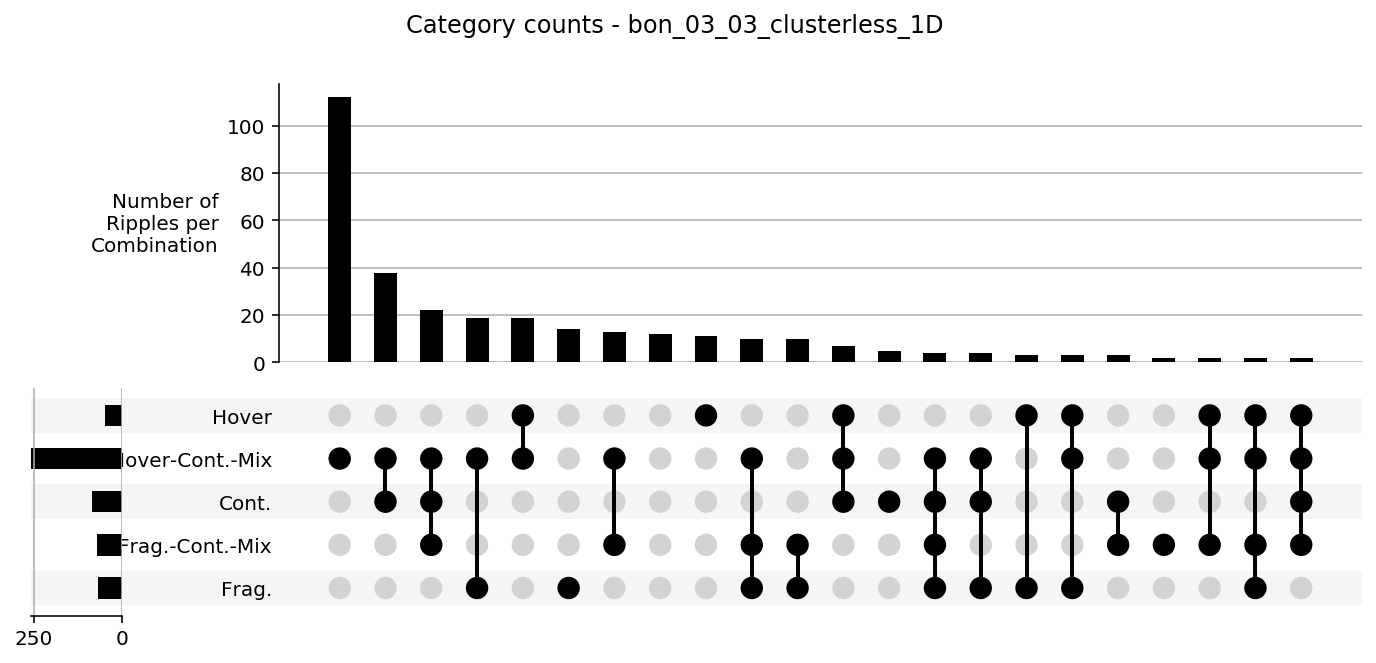

In [19]:
plot_category_counts(replay_info)
plt.suptitle(f"Category counts - {epoch_identifier}")
fig_name = f"{epoch_identifier}_category_counts.png"
fig_name = os.path.join(FIGURE_DIR, "sleep_category_counts_duration", fig_name)

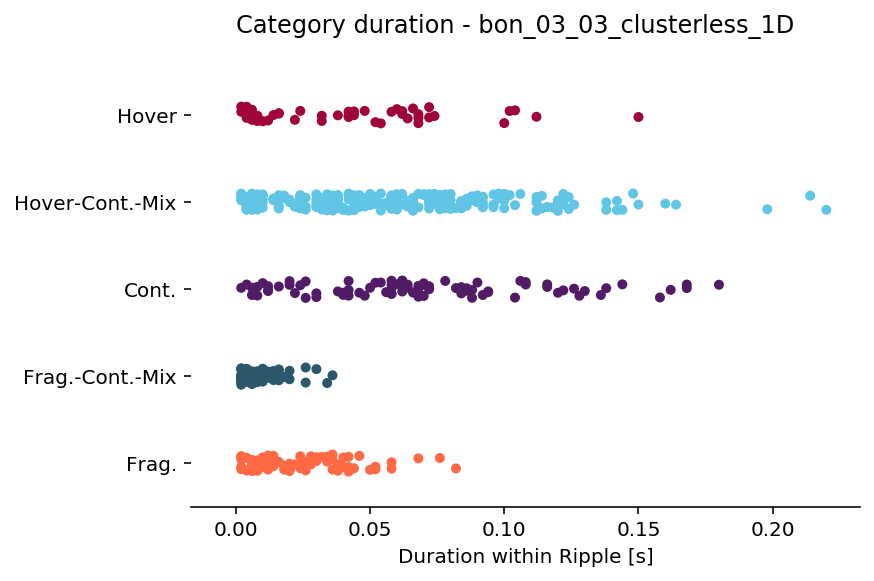

In [20]:
plot_category_duration(replay_info)
plt.suptitle(f"Category duration - {epoch_identifier}")
fig_name = f"{epoch_identifier}_category_duration.png"
fig_name = os.path.join(FIGURE_DIR, "sleep_category_counts_duration", fig_name)

In [21]:
place_field_max = get_place_field_max(classifier)
linear_position_order = place_field_max.argsort(axis=0).squeeze()

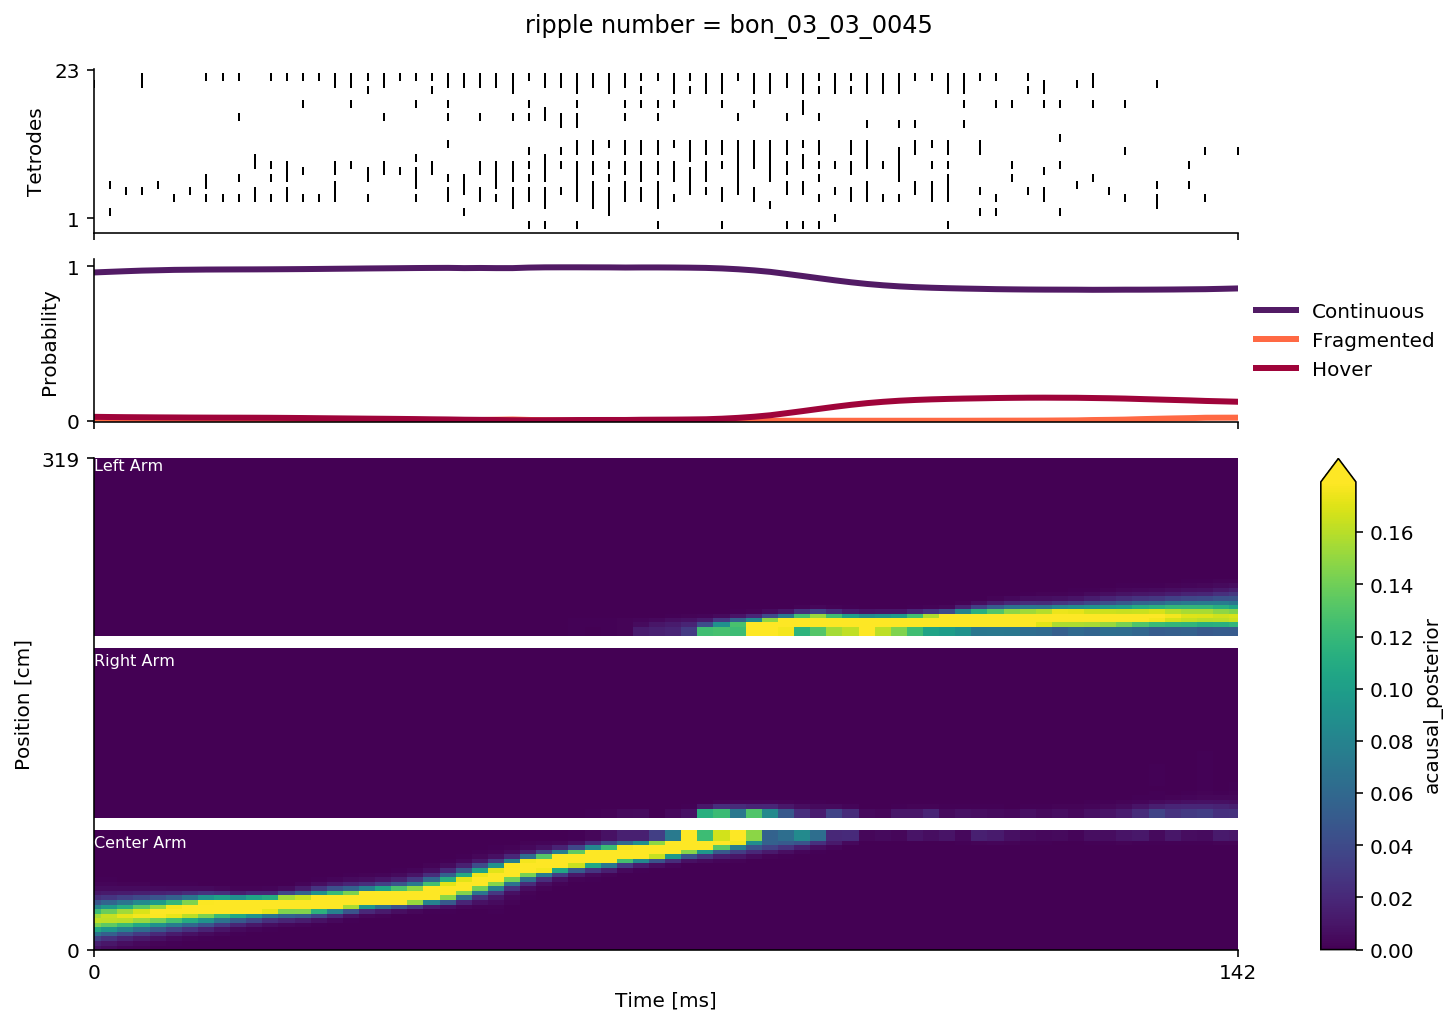

In [333]:
ripple_number = 45

posterior = (
    results.acausal_posterior.sel(ripple_number=ripple_number)
    .dropna("time", how="all")
    .assign_coords(time=lambda ds: 1000 * ds.time / np.timedelta64(1, "s"))
)
ripple_position = np.full_like(posterior.time.values, np.nan)
plot_ripple_decode_1D(
    posterior,
    ripple_position,
    ripple_spikes.loc[ripple_number],
    linear_position_order,
    data["position_info"],
    classifier,
    spike_label="Tetrodes",
)
plt.suptitle(
    f"ripple number = {sleep_epoch_key[0]}_"
    f"{sleep_epoch_key[1]:02d}_{sleep_epoch_key[2]:02d}"
    f"_{ripple_number:04d}"
)
fig_name = (
    f"{sleep_epoch_key[0]}_{sleep_epoch_key[1]:02d}_"
    f"{sleep_epoch_key[2]:02d}_{ripple_number:04d}_"
    f"{data_type}_{dim}_acasual_classification.png"
)
fig_name = os.path.join(FIGURE_DIR, "sleep_ripple_classifications", fig_name)

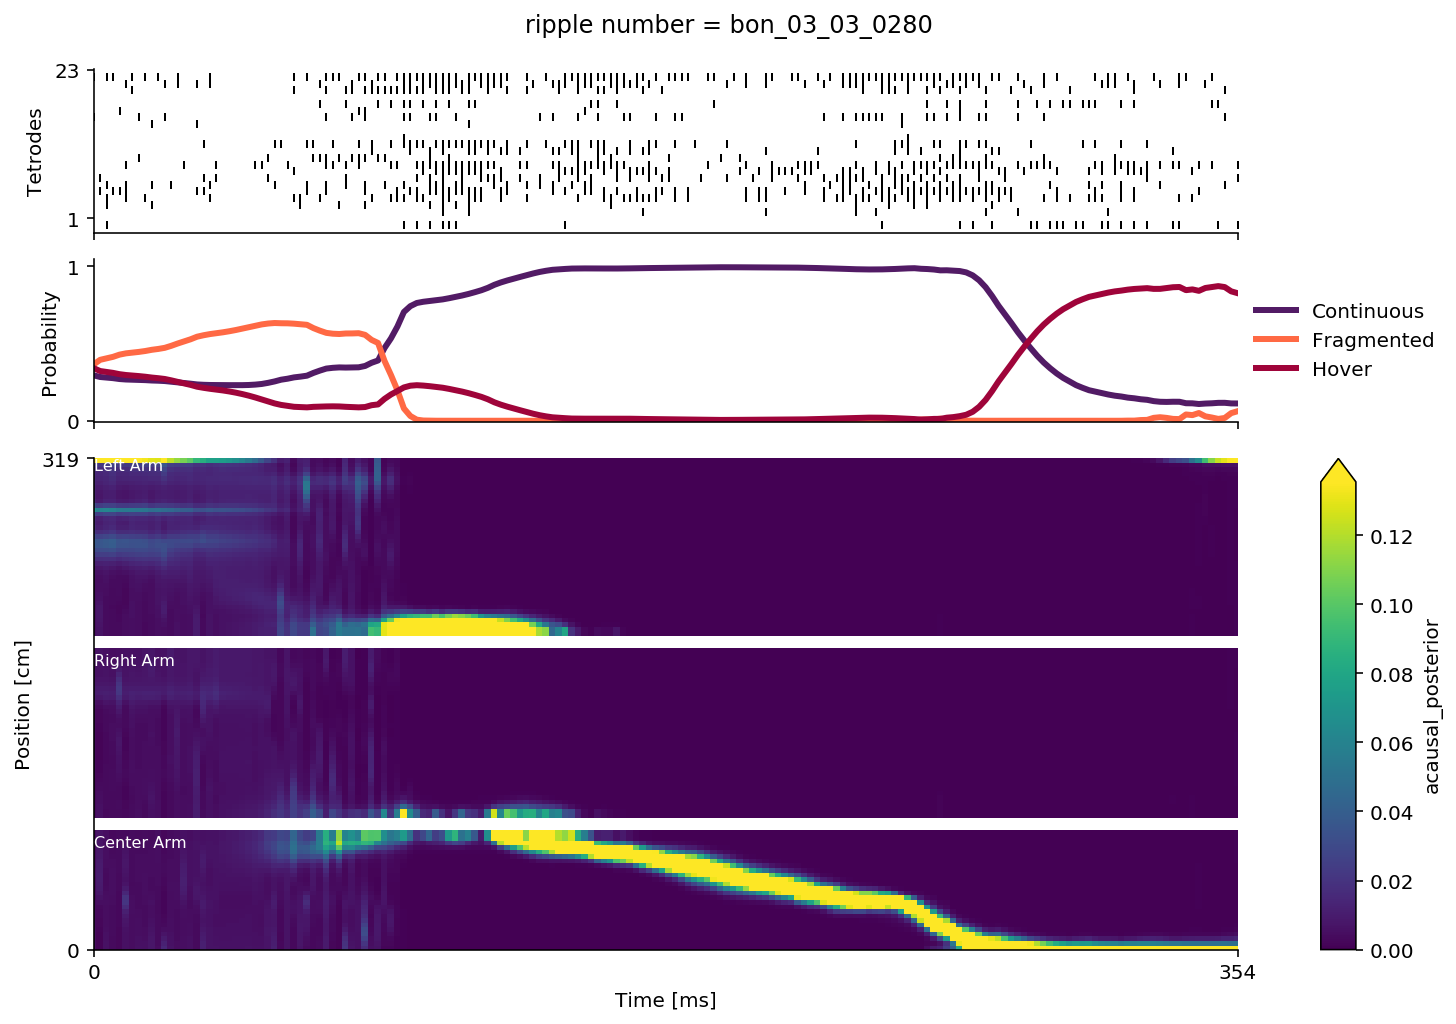

In [332]:
ripple_number = 280

posterior = (
    results.acausal_posterior.sel(ripple_number=ripple_number)
    .dropna("time", how="all")
    .assign_coords(time=lambda ds: 1000 * ds.time / np.timedelta64(1, "s"))
)
ripple_position = np.full_like(posterior.time.values, np.nan)
plot_ripple_decode_1D(
    posterior,
    ripple_position,
    ripple_spikes.loc[ripple_number],
    linear_position_order,
    data["position_info"],
    classifier,
    spike_label="Tetrodes",
)
plt.suptitle(
    f"ripple number = {sleep_epoch_key[0]}_"
    f"{sleep_epoch_key[1]:02d}_{sleep_epoch_key[2]:02d}"
    f"_{ripple_number:04d}"
)
fig_name = (
    f"{sleep_epoch_key[0]}_{sleep_epoch_key[1]:02d}_"
    f"{sleep_epoch_key[2]:02d}_{ripple_number:04d}_"
    f"{data_type}_{dim}_acasual_classification.png"
)
fig_name = os.path.join(FIGURE_DIR, "sleep_ripple_classifications", fig_name)